In [214]:
import requests
import json
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
launchpad_price_mint = {}

url = "http://api-mainnet.magiceden.dev/v2/launchpad/collections?offset=0&limit=500"
payload={}
headers = {}

response = requests.request("GET", url, headers=headers, data=payload)
response_json = response.json()

for n in range(0,len(response_json)):
    launchpad_price_mint.update(
        {
            response_json[n]['symbol']: response_json[n]['price']
        }
    )

In [71]:
collection_price_floor = {}

for key in launchpad_mint_price.keys():
    url = "http://api-mainnet.magiceden.dev/v2/collections/"+key+"/stats"
    payload= {}
    headers = {}

    response = requests.request("GET", url, headers=headers, data=payload)
    response_json = response.json()

    try:
        collection_price_floor.update(
            {
                response_json['symbol']: response_json['floorPrice']
            }
        )
    except:
        collection_price_floor.update(
            {
                response_json['symbol']: 0
            }
        )

In [88]:
collection_stats = {
    'symbol': list(launchpad_mint_price.keys()),
    'price_mint': list(launchpad_mint_price.values()),
    'price_floor': list(collection_price_floor.values())
}

In [ ]:
df = pd.DataFrame(collection_stats)
df = df[df.price_floor > 0].reset_index(drop=True) # Excluding collections with no floor price
df = df[df.price_mint > 0].reset_index(drop=True) # Excluding collections with no mint price

df['price_floor'] = df.price_floor.apply(lambda x: x / (10**9)) # price floor to 9 decimals
df['roi_times'] = df.price_floor / df.price_mint
# df.head()

In [120]:
def bin_mint(x):
    assigned_bin = ''

    if x < 1:
        assigned_bin = 'Less than 1'
    elif 1 <= x < 2:
        assigned_bin = '1-2'
    elif 2 <= x < 3:
        assigned_bin = '2-3'
    else:
        assigned_bin = 'More than 3'
    
    return assigned_bin

def bin_roi(x):
    assigned_bin = ''
    if x < 1:
        assigned_bin = 'Less than 1x Returns'
    elif 1 <= x < 5:
        assigned_bin = '1-5x Returns'
    elif 5 <= x < 10:
        assigned_bin = '5-10x Returns'
    elif 10 <= x < 20:
        assigned_bin = '10-20x Returns'
    else:
        assigned_bin = 'More than 20x Returns'

    return assigned_bin

df['bin_price_mint'] = df.price_mint.apply(bin_mint)
df['bin_returns'] = df.roi_times.apply(bin_roi)

___
## Results

In [209]:
binned_df = df.groupby(['bin_price_mint','bin_returns']).symbol.count().reset_index()

pivoted = binned_df.pivot(index='bin_price_mint',columns='bin_returns',values='symbol').reset_index()
pivoted = pivoted.fillna(0)
pivoted = pivoted.rename(columns={
        'bin_price_mint': 'Mint Price (SOL)'
    },
    index={
        0: 1,
        1: 2,
        2: 0,
        3: 3
    })
col_order = ['Mint Price (SOL)','Less than 1x Returns','1-5x Returns','5-10x Returns','10-20x Returns','More than 20x Returns']
pivoted = pivoted[col_order]

pivoted.sort_index(ascending=True, inplace=True)
pivoted.set_index('Mint Price (SOL)', inplace=True)
pivoted.columns.name = None

for column in pivoted.columns:
    pivoted[column] = pivoted[column].apply(
        lambda x: int(x)
    )

pivoted

,Less than 1x Returns,1-5x Returns,5-10x Returns,10-20x Returns,More than 20x Returns
Mint Price (SOL),,,,,
Less than 1,25,8,0,2,2
1-2,45,13,0,0,0
2-3,8,9,1,1,0
More than 3,0,1,0,0,0


Text(1.0, 1.0, 'MagicEden Launchpad: Returns based on Minting Price')

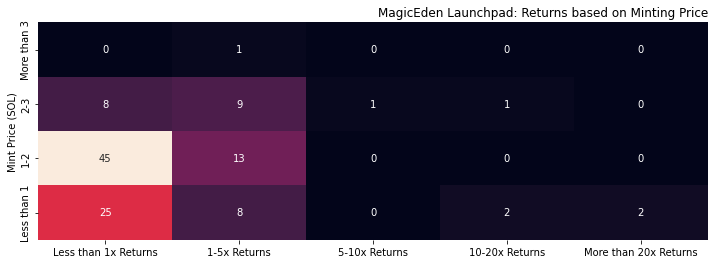

In [230]:
plt.figure(figsize=(12,4))
ax = sns.heatmap(pivoted, annot=True, cbar=False)
ax.invert_yaxis()
plt.title('MagicEden Launchpad: Returns based on Minting Price', 
    loc='right',
    size='large'
    )

In [205]:
# Flipside API export of labeled NFT collections ROI table
url = 'https://api.flipsidecrypto.com/api/v2/queries/67a16632-5fa8-4fcd-acd7-f12e03544d39/data/latest'
response = requests.request("GET", url)
response_json = response.json()

In [207]:
collections_flipside = pd.DataFrame(response_json)
collections_flipside['Mint Price (SOL)'] = collections_flipside['Mint Price (SOL)'].apply(
    lambda x: x[2:] # Trim value numbering
)
collections_flipside = collections_flipside[col_order]
collections_flipside.set_index('Mint Price (SOL)', inplace=True)

collections_flipside

,Less than 1x Returns,1-5x Returns,5-10x Returns,10-20x Returns,More than 20x Returns
Mint Price (SOL),,,,,
Less than 1,0,1,0,0,1
1-2,0,1,0,0,2
2-3,0,1,1,1,1
More than 3,0,0,1,1,1


Text(1.0, 1.0, 'MagicEden Popular Collections: Returns based on Minting Price')

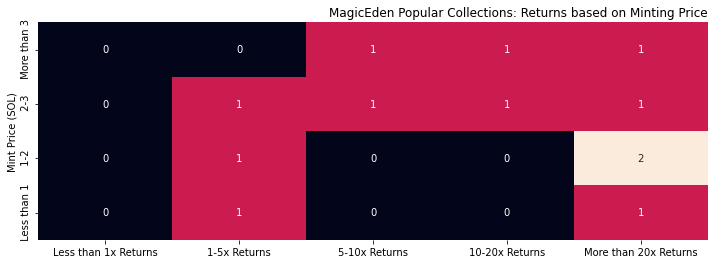

In [231]:
plt.figure(figsize=(12,4))
ax = sns.heatmap(collections_flipside, annot=True, cbar=False)
ax.invert_yaxis()
plt.title('MagicEden Popular Collections: Returns based on Minting Price', 
    loc='right',
    size='large'
    )